# Part 1: Data and Preprocessing

This notebook is the first in a series detailing our experiments. Here we describe the dataset and preprocessing pipeline.

In [2]:
# %matplotlib inline

from pathlib import Path

import dicom
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.utils.data

from itertools import filterfalse

### The Dataset

Our dataset consists of around 1,400 time-series DTI observations from the [Parkinson's Progression Markers Initiative](http://www.ppmi-info.org/) (PPMI). A sample of these have been included in the `data` directory at the root of this repository.

The data follows a directory structure `{PATIENT_ID}/{MODALITY}/{TIMESTAMP}/{OBSERVATION_ID}`. Each observation consist of 65 dicom files, one for each time step. Each dicom file contains up to 100, 116x116 image slices arranged in a grid.

Let's examine a single timeslice:

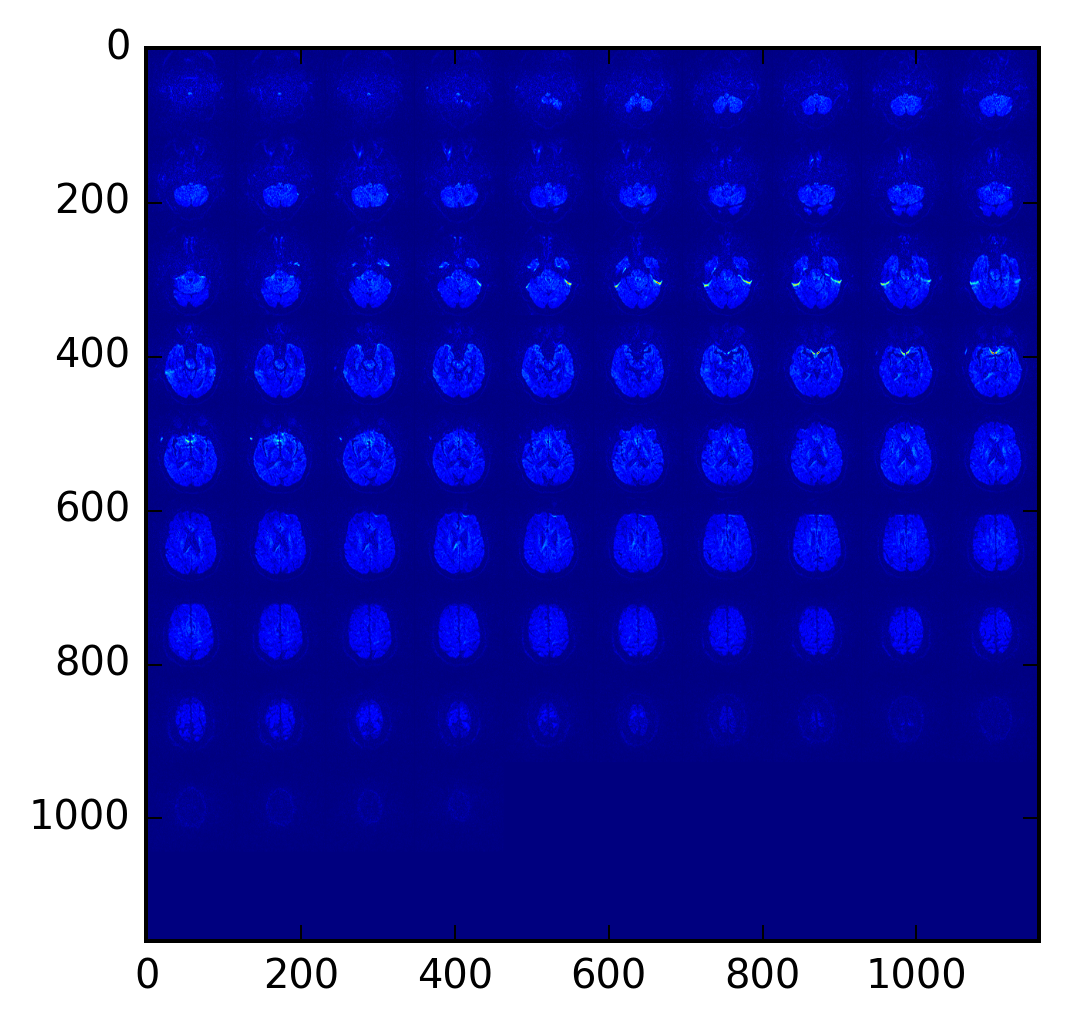

In [14]:
data_dir = Path('./data')
obs_dir = data_dir / '3107' / 'DTI_gated' / '2016-04-06_14_07_07.0' / 'S426370'
files = sorted(path for path in obs_dir.glob('*.dcm'))

data = [dicom.read_file(str(path)) for path in files]

fig, ax = plt.subplots(1, 1, dpi=288)
ax.imshow(data[0].pixel_array)

### Converting to 3D

We see that each dicom file gives us a 2D pixel array. The first step we need to perform is to convert this grid of slices into a 3D volume. We accomplish this by writing an iterator over the slices in the grid which we can then feed to `np.stack`. Some files contain a 9x9 grid of slices while others contain a 10x10 grid. Our iterator thus takes an argument `n` which specifies how many slices we should yield. If we exhaust the grid before yielding `n` slices, we continue to yield zeros.

In [4]:
def grid_to_slices(grid, slice_shape=(116, 116), n=100):
    '''Iterate over the sub-images in a pixel array.

    Args:
        grid (2D array):
            The raw pixel array from a dicom file.
            This array aranges the slices on a 2D grid.
        slice_shape (2D shape):
            The shape of the sub-images.
        n (positive int):
            The number of sub-images to yield.

    Yields (2D array):
        The sub-images having shape `slice_shape`.
    '''
    height, width = grid.shape
    h, w = slice_shape

    # Extract at most `n` slices from the pixel array
    for i in range(0, height, h):
        for j in range(0, width, w):
            if n > 0:
                s = grid[i:i+h, j:j+w]
                yield s
            n -= 1

    # If we've extracted less than `n`, yield zeros
    while n > 0:
        s = np.zeros(slice_shape)
        yield s
        n -= 1

grid shape:   (1160, 1160)
volume shape: (100, 116, 116)


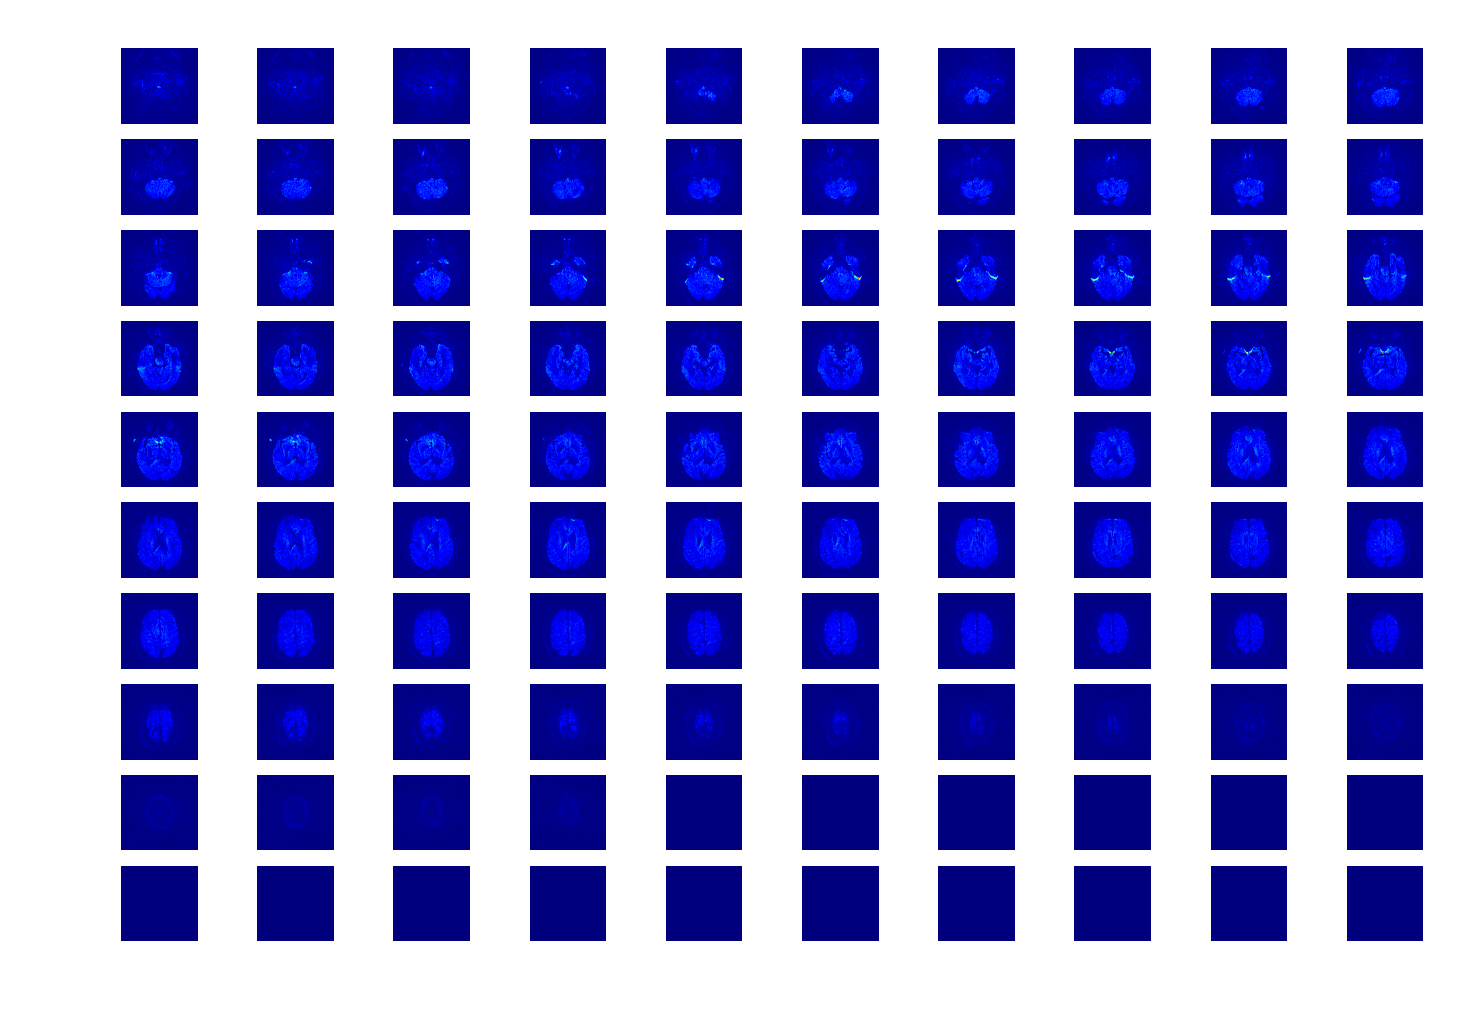

In [5]:
grid = data[0].pixel_array
slices = grid_to_slices(grid)
volume = np.stack(slices)

print('grid shape:  ', grid.shape)
print('volume shape:', volume.shape)
fig, axes = plt.subplots(10, 10, dpi=288)
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        im = volume[i*10 + j]
        ax.imshow(im, vmax=grid.max())
        ax.axis('off')

### Creating the Time Series

Now that we can open a single dicom file and convert its pixel array to a 3D volume, we need a function to open an entire time series observation. This process is straight forward: we open all dicoms for a single observation, convert each to 3D, then stack these volumes into a timeseries.

Additionally, we add a trivial "channel" dimension as the 2nd axis, where PyTorch expects it, and convert the volume from `uint16` to `float32`.

In [6]:
def try_pix_array(dcm_file):
    try:
        return dcm_file.pixel_array
    except NotImplementedError:
        pass
def try_slice(grid_slice, slice_shape):
    if grid_slice == False:
        return False
    else:
        return grid_to_slices(grid_slice, slice_shape=slice_shape)

def load_observation(obs_dir, slice_shape=(116, 116)):
    '''Load a single observation.

    Args:
        obs_dir (path):
            The path to the observation, a directory containing dicom files.
        slice_shape (2D shape):
            The shape of the individual images within a single pixel_array.
            See `grid_to_slices`.

    Returns (5D array):
        An array with the shape
        `(sequence length, features, depth, height, width)`
    '''
    obs_dir = Path(obs_dir)
    paths = sorted(path for path in obs_dir.glob('*.dcm'))
    try:
        dcs = (dicom.read_file(str(p)) for p in paths)
        grids = (dc.pixel_array for dc in dcs)
        slices = (grid_to_slices(g, slice_shape=slice_shape) for g in grids)
        stacks = (np.stack(s) for s in slices)
        obs = np.stack(stacks)
        obs = np.expand_dims(obs, 1)
        obs = obs.astype('float32')
        return obs
    except (NotImplementedError, ValueError):
        return np.nan


In [12]:
obs = load_observation(obs_dir)
obs = np.reshape(obs, (65,100,116,116))
obs.shape

(65, 100, 116, 116)

### Loading the Labels

Our labels are stored in a file `metadata.csv` at the root of the data directory. This file may contain metadata for more observations than we actually have, so we cross reference each of our actual observations against this file to build a list of metadata dictionaries.

In [15]:
def metadata(data_dir):
    '''Load the metadata for the dataset.

    A file `metadata.csv` should be stored in the same directory as the data.
    This file is cross-referenced with the actual data to only include metadata
    for the samples that actually exist locally.

    Args:
        data_dir (path):
            The root directory of the dataset.

    Returns (list of dict, one for each observation):
        path (path):
            The directoy containing the dicoms for the observation.
        label (bool):
            True if the observation is in the Parkinson's class.
    '''
    # The list of metadata dicts for each observation.
    ret = []

    # Things which might exist in the data_dir that are not data.
    ignore = ['.DS_Store', 'metadata.csv', 'output', '.ipynb_checkpoints']

    # Open the metadata csv
    data_dir = Path(data_dir)
    meta = pd.read_csv(data_dir / 'metadata.csv')
    meta = meta.sort_values('Subject')
    meta = meta[['Subject', 'Group']]
    meta = meta.drop_duplicates()
    meta = meta.set_index('Subject')

    data_dir = Path(data_dir)
    for path in data_dir.glob('*'):
        if path.name in ignore: continue
        subject = int(path.name)
        label = meta.loc[subject]['Group'] == 'PD'
        label = int(label)
        paths = Path(path).glob(f'DTI_gated/*/*')
        paths = (p for p in paths if p.name not in ignore)
        ret.extend({
            'path': p,
            'label': label,
        } for p in paths)
    return ret

In [9]:
class PPMIDataset(torch.utils.data.Dataset):
    '''An implementation of the torch `Dataset` interface for our dataset.
    '''
    def __init__(self, data_dir):
        self.meta = metadata(data_dir)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, i):
        meta = self.meta[i]
            
        x = load_observation(meta['path'])
        
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
            y = meta['label']
            return x, y
        else:
            return torch.IntTensor(1).zero_(), torch.IntTensor(1).zero_()


In [10]:
def load_dataset(data_dir, **kwargs):
    '''Creates a torch `DataLoader` that iterates over our dataset out-of-core.

    Args:
        data_dir (path):
            The path to the dataset.

    Kwargs:
        The kwargs are forwarded to the DataLoader constructor.
        The following kwrags have different defaults:

        batch_size (int):
            The number of samples per batch.
            Defaults to 1.
        shuffle (bool):
            Iterate over the epoch in a random order.
            Defaults to True.
        num_workers (int):
            The number of background processes prefetching the data.
            Defaults to 4.
        pin_memory (bool):
            Load the data into cuda pinned memory.
            Defaults to True if cuda is available.

        For the full list of kwargs, see `torch.utils.data.DataLoader`.

    Returns (torch.utils.data.DataLoader):
        A DataLoader that iterates over batches of the dataset for one epoch.
    '''
    kwargs.setdefault('batch_size', 1)
    kwargs.setdefault('shuffle', True)
    kwargs.setdefault('num_workers', 4)
    kwargs.setdefault('pin_memory', torch.cuda.is_available())

    ds = PPMIDataset(data_dir)

    return torch.utils.data.DataLoader(ds, **kwargs)



In [16]:
loader = iter(load_dataset(data_dir))
batch = next(loader)
x, y = batch
print('dtype')
print(' inputs:', x.type())
print(' labels:', y.type())
print('shape')
print(' inputs:', x.shape)
print(' labels:', y.shape)

dtype
 inputs: torch.FloatTensor
 labels: torch.LongTensor
shape
 inputs: torch.Size([1, 65, 1, 100, 116, 116])
 labels: torch.Size([1])


### Wrapping Up

We now have all the functionality required to efficiently iterate over our data.